In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding
import matplotlib.pyplot as plt

import numpy as np
import pylab as pb
import GPy 
# %pylab inline
def get_predictions(X,Y,error):
    X = (X - np.mean(X))/np.std(X)
    mm = np.mean(Y)
    ss = np.std(Y)
    Y = (Y-np.mean(Y))/ss
    kern =  GPy.kern.RBF(input_dim=1) + GPy.kern.MLP(1) 
    Y_meta = {'output_index':np.arange(len(Y))[:,None]}
    m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern,Y_metadata=Y_meta)
    m['.*het_Gauss.variance'] = np.abs(error)[:,None] #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    m.optimize()
    preds,varss  = m.predict(m.X,full_cov=False,Y_metadata=None,kern=None,likelihood=None,include_likelihood=False)
    return preds*ss+mm,varss

def weighted_mean(self, weights, **kwargs):
    weights = self._shallow_copy(weights)
    window = self._get_window(weights)

    def _get_weighted_mean(X, Y):
        X = X.astype('float64')
        Y = Y.astype('float64')
        sum_f = lambda x: x.rolling(window, self.min_periods, center=self.center).sum(**kwargs)
        return sum_f(X * Y) / sum_f(Y)

    return _flex_binary_moment(self._selected_obj, weights._selected_obj,
                               _get_weighted_mean, pairwise=True)

def dump_data(directory_ema,directory1,directory2,f):
    if f not in os.listdir(directory_ema):
        return 0
    data = pickle.load(open(directory1+f,'rb'))
    a = data[0]
    this_participant = []
    stress_all = a[['time','ltime','user','stress_likelihood_ppg','quality_mag','day','activity','hand','rr_weighted_features']].dropna()
    stress_all['hr'] = stress_all['rr_weighted_features'].apply(lambda a:a[-5])
    stress_days = [a for i,a in stress_all.groupby(['hand','day'],as_index=False) if a.shape[0]>180]
    _Rolling_and_Expanding.weighted_mean = weighted_mean
    for a in stress_days:
        a = a.dropna().sort_values('time').reset_index(drop=False)
        a['stress_likelihood_ppg_qual'] = a['stress_likelihood_ppg'].rolling(window = 7).weighted_mean(a['quality_mag'])
        a['qual'] = a['quality_mag'].rolling(window = 7).weighted_mean(a['quality_mag'])
        a['hr'] = a['hr'].rolling(window = 7).weighted_mean(a['quality_mag'])
        a = a.dropna()
        preds,varss = get_predictions(a['time'].values,a['stress_likelihood_ppg_qual'].values,(1.1-a['quality_mag'].values)/2)
        a['stress_final'] = preds
#         print(preds)
#         plt.plot(a['ltime'],a['stress_final'])
#         plt.show()
        this_participant.append(a)
        print(a.shape)
    data = pd.concat(this_participant).dropna().sort_values('time').reset_index(drop=True)
#     left_data = data[data.hand=='left']
#     right_data = data[data.hand=='right']
#     left_daywise_data = [a for i,a in left_data.groupby(['day'],as_index=False) if a.shape[0]>180]
#     participant_mean = np.average(data['stress_likelihood_ppg_qual'],weights=data['qual'])
#     print(participant_mean)
#     for a in left_daywise_data:
#         a = a.sort_values('ltime').reset_index(drop=False)
#         a['mean1'] = participant_mean
#         a['diff1'] = a['mean1'] - a['stress_final']
#         a['after'] = list(a['diff1'].values)[1:] + [np.nan]
#         a['ind'] = 0
#         a['ind'].loc[(a.diff1>0)&(a.after<0)] = -1
#         a['ind'].loc[(a.diff1<0)&(a.after>0)] = 1
        
# #         for j,row in a.iterrows():
# #             if row['ind']
#         print(a.head())
# #         print(a.head())
# #         a.set_index('ltime',inplace=True)
# #         a = a.resample('1min').mean().reset_index(drop=False)
# #         print(a['ltime'].min(),a['ltime'].max(),a.columns)
        
#         plt.plot(a['ltime'],a['stress_final'])
#         plt.hlines(participant_mean,a['ltime'].min(),a['ltime'].max())
#         plt.plot(a['ltime'],a['ind'])
#         plt.show()
    ema = pickle.load(open(directory_ema+f,'rb'))
    ema = ema.sort_values('score').reset_index(drop=True)
    ema['label'][ema['score']<=np.mean(ema['score'])] = 0
    ema['label'][ema['score']>np.mean(ema['score'])] = 1
    pickle.dump([data,ema],open(directory2+f,'wb'))
    return 0

directory1 = '../../cc3/rice_data/after_computation/ecg_ppg_final_day_5/'
directory2 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_final_pred_day_5/'
if not os.path.isdir(directory2):
    os.makedirs(directory2)
directory_ema = '../../cc3/rice_data/ecg_ppg_ema_final/'
from joblib import Parallel,delayed
output = Parallel(n_jobs=30,verbose=3)(delayed(dump_data)(directory_ema,directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p')    
# output = [dump_data(directory_ema,directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p']   
#         plt.figure(figsize=(18,10))
#         plt.plot(a['time'],a['stress_likelihood_ppg_qual'],'*-r')
#         plt.plot(a['time'],a['hr']/np.max(a['hr']),'o-c')
#         plt.title(np.max(a['hr']))
#         plt.bar(a['time'],a['qual'],50)
#         plt.show()

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  67 out of  94 | elapsed:  9.2min remaining:  3.7min
[Parallel(n_jobs=30)]: Done  94 out of  94 | elapsed: 13.2min finished


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import pickle
from joblib import Parallel,delayed
import matplotlib.pyplot as plt

def make_episodes(directory_ema,directory1,directory2,f):
    if f not in os.listdir(directory_ema):
        return 0
    data = pickle.load(open(directory1+f,'rb'))
    a = data[0]
    participant_mean = np.average(a['stress_final'],weights=a['qual'])
    stress_days = [df for i,df in a.groupby(['hand','day'],as_index=False) if a.shape[0]>180]
    this_participant = []
    for a in stress_days:
        a = a.sort_values('ltime').reset_index(drop=False)
        a['mean1'] = participant_mean
        a['diff1'] = a['mean1'] - a['stress_final']
        a['after'] = list(a['diff1'].values)[1:] + [np.nan]
        a['ind'] = 0
        a['ind'].loc[(a.diff1>0)&(a.after<0)] = -1
        a['ind'].loc[(a.diff1<0)&(a.after>0)] = 1
#         plt.rcParams.update({'font.size':20})
#         plt.figure(figsize=(18,10))
#         plt.plot(a['ltime'],a['stress_final'],'*-r',label='Stress Likelihood')
#         plt.hlines(participant_mean,a['ltime'].min(),a['ltime'].max(),label='Participant Average')
#         a['stress_final1'] = a['stress_final']
#         a['stress_final1'][a['stress_final1']<=participant_mean] = participant_mean
#         plt.fill_between(a['ltime'],participant_mean,a['stress_final1'],label='Stress Episodes')
#         plt.legend()
#         plt.ylim([0,1])
#         plt.show()
        
        if len(a['ind'].unique())==1:
            continue
        start = True
        i = 0
        k = -1
        all_episodes = []
        for j,row in a.iterrows():
            if start:
                if row['ind']==0:
                    continue
                elif row['ind'] ==-1:
                    i = j
                    start=False
                elif row['ind'] == 1:
                    i = 0
                    k = j
                    if k-i>4:
                        temp = []
                        temp.extend([row['user'],row['day'],row['hand'],row['time'],row['ltime'],a.loc[i:k]])
#                         print(a.loc[i:k]['ind'])
                        all_episodes.append(temp)
                    start = False
            else:
                if row['ind']==0:
                    continue
                elif row['ind'] ==-1:
                    i = j
                elif row['ind'] == 1:
                    k = j
                    if k-i>4:
                        temp = []
                        temp.extend([row['user'],row['day'],row['hand'],row['time'],row['ltime'],a.loc[i:k]])
#                         print(a.loc[i:k]['ind'])
                        all_episodes.append(temp)
        if k<i:
            k = a.shape[0]
            if k-i>4:
                temp = []
                temp.extend([a['user'].loc[int(i+k)//2],a['day'].loc[int(i+k)//2],
                             a['hand'].loc[int(i+k)//2],a['time'].loc[int(i+k)//2],
                             a['ltime'].loc[int(i+k)//2],a.loc[i:k]])
                all_episodes.append(temp)
        
        data = pd.DataFrame(all_episodes,columns=['user','day','hand','time','ltime','data'])
        for i,row in data.iterrows():
            print(row['data']['ind'].values[0],row['data']['ind'].values[-1],row['data'].shape,a.shape)
        print('-'*4)
        this_participant.append(data)
    data = pd.concat(this_participant).dropna().sort_values('time').reset_index(drop=True)
    data['participant_mean'] = participant_mean
    ema = pickle.load(open(directory_ema+f,'rb'))
    ema = ema.sort_values('score').reset_index(drop=True)
    ema['label'][ema['score']<=np.mean(ema['score'])] = 0
    ema['label'][ema['score']>np.mean(ema['score'])] = 1
    pickle.dump([data,ema],open(directory2+f,'wb'))
    return 0

directory1 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_final_pred_day_5/'
directory2 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_episode_day_5/'
directory_ema = '../../cc3/rice_data/ecg_ppg_ema_final/'
if not os.path.isdir(directory2):
    os.makedirs(directory2)
# output = [make_episodes(directory_ema,directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p']   
output = Parallel(n_jobs=30,verbose=3)(delayed(make_episodes)(directory_ema,directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p')    


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  46 out of  78 | elapsed:    7.4s remaining:    5.2s
[Parallel(n_jobs=30)]: Done  73 out of  78 | elapsed:   14.4s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  78 out of  78 | elapsed:   16.6s finished


In [3]:
import warnings
import pickle
import numpy as np
import pandas as pd
from joblib import Parallel,delayed
def get_expo(directory1,directory2,f):
    if f[-1]!='p':
        return 0
    data,ema = pickle.load(open(directory1+f,'rb'))
    ema = ema.sort_values('score').reset_index(drop=True)
#     ema['happy'] = ema['all_scores'].apply(lambda a:a[0])
#     ema['joyful'] = ema['all_scores'].apply(lambda a:a[1])
#     ema['nervous'] = ema['all_scores'].apply(lambda a:a[2])
#     ema['sad'] = ema['all_scores'].apply(lambda a:a[3])
#     ema['angry'] = ema['all_scores'].apply(lambda a:a[4])
#     labels = ema[['happy','joyful','nervous','sad','angry']].values
#     for j in range(labels.shape[1]):
#         t = labels[:,j]
#         t[t<=np.mean(t)] = 0
#         t[t!=0] = 1
#         labels[:,j] = t
#     labels = np.sum(labels,axis=1)
#     labels[labels<=2] = 0
#     labels[labels!=0] = 1
#     ema['label'] = labels
    all_data = []
    for i,df in data.groupby(['hand','day'],as_index=False):
        ema_day = ema[ema.day.isin(df['day'].values[:1])]
        participant_mean = df['participant_mean'].values[0]
        if ema_day.shape[0]==0:
            continue
#         print(df.shape,ema_day.shape)
        df['start'] = df['data'].apply(lambda a:a['time'].min())
        df['end'] = df['data'].apply(lambda a:a['time'].max())
        df['density']  = df['data'].apply(lambda a:np.average(a['stress_final'],weights=a['qual']))
        df['sum_density']  = df['data'].apply(lambda a:a['stress_final'].sum())
        df['max_density']  = df['data'].apply(lambda a:a['stress_final'].max())
        df['length_episode']  = df['data'].apply(lambda a:a.shape[0])
        df['qual']  = df['data'].apply(lambda a:np.average(a['qual']))
#         df = df[df.max_density>=2*participant_mean]
        for j,row in ema_day.iterrows():
            df_ema = df[(df.start<(row['time']-5*60))]
            if df_ema.shape[0]==0:
                temp = []
                temp.extend([row['time'],df['user'].values[0],df['hand'].values[0],df['day'].values[0]])
                distance = 0
                temp.append(0)
                temp.append(0)
                temp.append(0)
                temp.append(row['label'])
                all_data.append(temp)
                continue
            for k,row1 in df_ema.iterrows():
                temp = []
                temp.extend([row['time'],df['user'].values[0],df['hand'].values[0],df['day'].values[0]])
                if (row1['start']< row['time']) & (row1['end']<= row['time']):
                    distance = ((row['time'] - row1['start']) + (row['time'] - row1['end']))/2
                    temp.append(distance/3600)
                    temp.append(row1['length_episode'])
                    temp.append(row1['sum_density'])
                    temp.append(row1['qual'])
                    temp.append(row['label'])
                    all_data.append(temp)
                elif row1['end'] > row['time'] and row1['start'] < row['time']:
                    distance = 0
                    dd = row1['data']
                    dd = dd[dd.time<=row['time']]
                    temp.append(distance)
                    temp.append(dd.shape[0])
                    temp.append(dd['stress_final'].sum())
                    temp.append(dd['qual'].mean())
                    temp.append(row['label'])
#                 if df['user'].values[0]=='8008f00d-2549-46e4-ab1f-01542c1076e2':
#                     print(temp[1:])
                    all_data.append(temp)
            
                
                
    data = pd.DataFrame(all_data,columns=['time','user','hand','day','distance','length_episode','sum_episode','qual','label'])
    pickle.dump(data,open(directory2+f,'wb'))
    return 0

warnings.filterwarnings('ignore')
directory1 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_episode_day_5/'
directory2 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_exponential/'
if not os.path.isdir(directory2):
    os.makedirs(directory2)
output = Parallel(n_jobs=30,verbose=3)(delayed(get_expo)(directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p')  
# output = [get_expo(directory1,directory2,f) for f in os.listdir(directory1) if f[:-2]=='8008f00d-2549-46e4-ab1f-01542c1076e2']
#             print(df_ema.shape,'ema',df.shape,row['label'])         

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  46 out of  78 | elapsed:   10.2s remaining:    7.1s
[Parallel(n_jobs=30)]: Done  73 out of  78 | elapsed:   21.2s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  78 out of  78 | elapsed:   24.4s finished


In [8]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from joblib import Parallel,delayed
from copy import deepcopy


all_data = []
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def f1Bias_scorer_CV_2(probs, y, ret_bias=False):
    fpr, tpr, thresholds = roc_curve(y, probs)
    f1 = 0.0
    bias = 0
    for i in range(0, len(thresholds)):
        temp_y_pred = deepcopy(y)
        temp_y_pred[temp_y_pred>thresholds[i]] = 1
        temp_y_pred[temp_y_pred<=thresholds[i]] = 0
        f = f1_score(y,np.int32(temp_y_pred))
        if f > f1:
            f1 = f
            bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def get_auc(data,p):
    label_col = []
    y_pred = []
    for i,df1 in data.groupby(['day','user','hand','time'],as_index=False):
        df = df1[['label','sum_episode','distance']].dropna()
        if df.shape[0]==0:
            continue
        label_col.append(df['label'].unique()[0])
        y_pred.append(np.sum(df['sum_episode']*np.exp(-1*(df['distance']/p))))
    try:
        print(len(label_col))
        return my_score_auc(label_col,y_pred),label_col,y_pred
    except:
        return 0
def get_all_auc(directory2,f):
    data = pickle.load(open(directory2+f,'rb'))
    if len(data['label'].unique())==1:
        return -1
    if len(data['time'].unique())<10:
        return -1
    auc_col_all = Parallel(n_jobs=40,verbose=3)(delayed(get_auc)(data,p) for p in np.linspace(.0001,5,500))
    auc_all = np.array([a[0] for a in auc_col_all if a[0]!=np.nan])
    ind_max = np.argmax(auc_all)
    y,probs = auc_col_all[ind_max][1:]
    if len(np.unique(y))==1:
        return -1
    print(len(probs),sum(y))
    a,b = f1Bias_scorer_CV_2(np.array(probs), np.array(y), ret_bias=True)
    probs = np.array(probs)
    probs[probs<=b] = 0
    probs[probs>b] = 1
    print(confusion_matrix(y,probs))
    print('--'*20,np.max(auc_all),f1_score(y,probs))
    return np.max(auc_all)


directory2 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_exponential/'

# auc_col = Parallel(n_jobs=30,verbose=3)(delayed(get_all_auc)(directory2,f) for f in os.listdir(directory2) if f[-1]=='p')  
auc_col = [get_all_auc(directory2,f) for f in os.listdir(directory2) if f[-1]=='p']
auc_col = np.array(auc_col)
auc_col = auc_col[auc_col>-1]
#     print(data)
#     import matplotlib.pyplot as plt
# #     plt.figure(figsize=(12,8))
# #     # sns.jointplot(x='distance', y='sum_episode', kind="hex", color="k",data=data[data.label==0])
# #     plt.boxplot([data[data.label==1]['distance'],data[data.label==0]['distance']],showfliers=False)
# #     plt.show()
    
#     plt.figure(figsize=(12,8))
#     plt.hist(data[data.label>=1]['distance'],density=True,alpha=.5,label='Stress')
#     plt.hist(data[data.label<=0]['distance'],density=True,alpha=.5,label='Not Stress')
#     plt.legend()
#     # plt.xticks(rotation=10)
#     plt.show()
#     print('-'*400)
#     all_data.append(data)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


18 5
[[ 3 10]
 [ 1  4]]
---------------------------------------- 0.3384615384615385 0.4210526315789473


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


16 2
[[13  1]
 [ 1  1]]
---------------------------------------- 0.7142857142857143 0.5


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


11 2.0
[[0 9]
 [0 2]]
---------------------------------------- 0.6111111111111112 0.3076923076923077


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


26 22
[[ 0  4]
 [ 0 22]]
---------------------------------------- 0.3977272727272727 0.9166666666666666


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


11 3.0
[[1 7]
 [0 3]]
---------------------------------------- 0.5 0.4615384615384615


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


13 2.0
[[ 1 10]
 [ 0  2]]
---------------------------------------- 0.6363636363636364 0.2857142857142857


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


24 11.0
[[ 2 11]
 [ 2  9]]
---------------------------------------- 0.6993006993006994 0.5806451612903226


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


9 5.0
[[1 3]
 [1 4]]
---------------------------------------- 0.65 0.6666666666666666


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


22 3.0
[[ 3 16]
 [ 1  2]]
---------------------------------------- 0.5789473684210527 0.1904761904761905


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


20 6.0
[[9 5]
 [2 4]]
---------------------------------------- 0.7440476190476191 0.5333333333333333


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


20 16
[[ 3  1]
 [ 3 13]]
---------------------------------------- 0.65625 0.8666666666666666


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


27 13
[[13  1]
 [ 9  4]]
---------------------------------------- 0.5989010989010989 0.4444444444444444


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


21 18.0
[[ 0  3]
 [ 1 17]]
---------------------------------------- 0.38888888888888895 0.8947368421052632


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


25 6.0
[[ 1 18]
 [ 0  6]]
---------------------------------------- 0.868421052631579 0.4


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


16 15.0
[[ 1  0]
 [ 1 14]]
---------------------------------------- 1.0 0.9655172413793104


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


16 4.0
[[ 0 12]
 [ 0  4]]
---------------------------------------- 0.5 0.4


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


20 3.0
[[ 0 17]
 [ 0  3]]
---------------------------------------- 0.803921568627451 0.2608695652173913


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


35 20.0
[[ 0 15]
 [ 0 20]]
---------------------------------------- 0.6466666666666667 0.7272727272727273


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


29 17.0
[[ 9  3]
 [ 5 12]]
---------------------------------------- 0.7990196078431373 0.7500000000000001


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


38 25.0
[[ 7  6]
 [15 10]]
---------------------------------------- 0.5261538461538462 0.48780487804878053


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


31 11.0
[[ 5 15]
 [ 2  9]]
---------------------------------------- 0.5181818181818182 0.5142857142857142


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


38 12.0
[[18  8]
 [ 7  5]]
---------------------------------------- 0.5689102564102564 0.4


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


28 20.0
[[ 0  8]
 [ 0 20]]
---------------------------------------- 0.6 0.8333333333333333


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


49 6.0
[[29 14]
 [ 4  2]]
---------------------------------------- 0.5697674418604651 0.18181818181818182


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


36 6.0
[[ 0 30]
 [ 0  6]]
---------------------------------------- 0.7888888888888889 0.2857142857142857


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


25 4.0
[[ 0 21]
 [ 0  4]]
---------------------------------------- 0.47619047619047616 0.2758620689655173


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


29 11
[[12  6]
 [ 9  2]]
---------------------------------------- 0.4267676767676768 0.2105263157894737


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


44 20.0
[[17  7]
 [12  8]]
---------------------------------------- 0.5895833333333333 0.4571428571428572


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


41 24.0
[[ 0 17]
 [ 0 24]]
---------------------------------------- 0.3651960784313726 0.7384615384615384


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.3s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


52 17.0
[[ 0 35]
 [ 0 17]]
---------------------------------------- 0.5294117647058824 0.4927536231884058


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    5.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


62 23.0
[[ 0 39]
 [ 0 23]]
---------------------------------------- 0.7157190635451504 0.5411764705882353


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


22 5.0
[[ 0 17]
 [ 1  4]]
---------------------------------------- 0.3999999999999999 0.3076923076923077


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


40 20.0
[[ 0 20]
 [ 0 20]]
---------------------------------------- 0.5575 0.6666666666666666


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


37 6.0
[[20 11]
 [ 2  4]]
---------------------------------------- 0.6075268817204301 0.3809523809523809


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


20 10.0
[[ 1  9]
 [ 0 10]]
---------------------------------------- 0.9099999999999999 0.6896551724137931


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


31 17.0
[[ 0 14]
 [ 1 16]]
---------------------------------------- 0.3529411764705882 0.6808510638297872


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


43 6.0
[[19 18]
 [ 2  4]]
---------------------------------------- 0.8063063063063063 0.28571428571428575


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


30 13.0
[[ 0 17]
 [ 0 13]]
---------------------------------------- 0.6334841628959276 0.6046511627906976


[Parallel(n_jobs=40)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 209 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


30 9.0
[[15  6]
 [ 1  8]]
---------------------------------------- 0.8941798941798942 0.6956521739130435


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


45 20.0
[[ 0 25]
 [ 0 20]]
---------------------------------------- 0.404 0.6153846153846153


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


16 6.0
[[ 0 10]
 [ 0  6]]
---------------------------------------- 0.6499999999999999 0.5454545454545454


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    1.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


17 11.0
[[6 0]
 [5 6]]
---------------------------------------- 0.7272727272727273 0.7058823529411764


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


39 21.0
[[13  5]
 [13  8]]
---------------------------------------- 0.6005291005291006 0.47058823529411764


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.0s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    6.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


70 20.0
[[ 0 50]
 [ 0 20]]
---------------------------------------- 0.372 0.4444444444444445


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


32 4
[[ 1 27]
 [ 0  4]]
---------------------------------------- 0.7946428571428572 0.2285714285714286


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


37 18.0
[[ 0 19]
 [ 0 18]]
---------------------------------------- 0.8011695906432749 0.6545454545454547


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    5.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


58 12.0
[[ 3 43]
 [ 2 10]]
---------------------------------------- 0.5507246376811594 0.3076923076923077


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    4.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


37 29.0
[[ 4  4]
 [15 14]]
---------------------------------------- 0.5474137931034483 0.5957446808510638


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done 336 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


37 31.0
[[ 5  1]
 [13 18]]
---------------------------------------- 0.6666666666666667 0.72


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    3.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    7.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


78 4.0
[[ 0 74]
 [ 0  4]]
---------------------------------------- 0.30405405405405406 0.09756097560975609


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    2.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


56 8
[[26 22]
 [ 4  4]]
---------------------------------------- 0.5989583333333333 0.23529411764705882


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    3.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    8.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


92 40.0
[[ 2 50]
 [ 4 36]]
---------------------------------------- 0.5326923076923077 0.5714285714285715


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    3.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    6.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


71 32.0
[[26 13]
 [21 11]]
---------------------------------------- 0.5480769230769231 0.39285714285714285


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    3.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    7.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


77 38.0
[[ 6 33]
 [ 7 31]]
---------------------------------------- 0.4750337381916329 0.6078431372549019


[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    4.0s


100 48.0
[[ 0 52]
 [ 0 48]]
---------------------------------------- 0.5552884615384615 0.6486486486486487


[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:    8.8s finished


<BarContainer object of 55 artists>

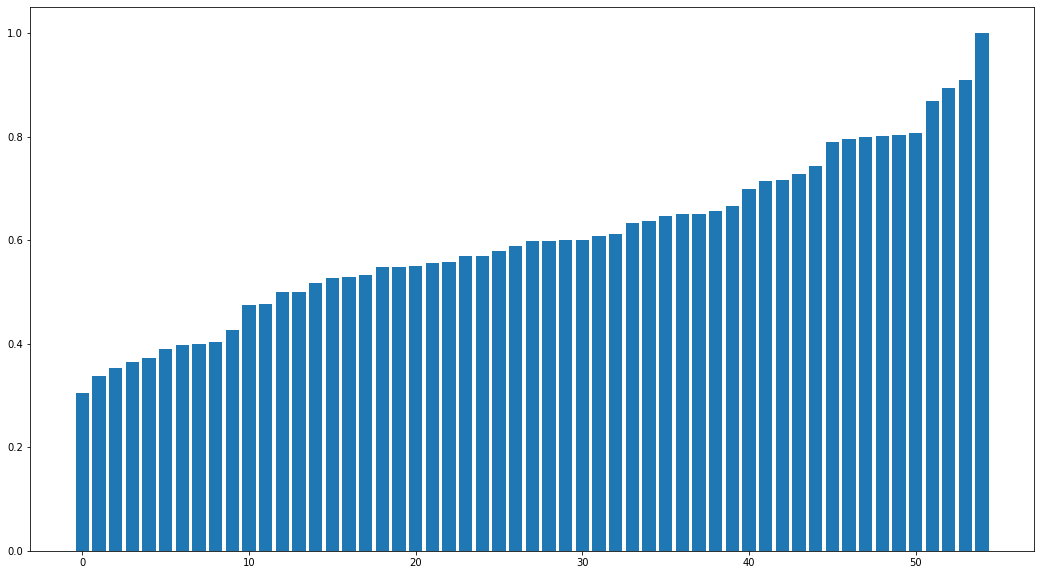

In [5]:
plt.figure(figsize=(18,10))
plt.bar(np.arange(len(auc_col)),sorted(auc_col))

In [6]:
np.median(auc_col)

0.5989010989010989

In [ ]:
data = pd.concat(all_data)

In [ ]:
import seaborn as sns

In [ ]:
data = data[data.distance<1]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
# sns.jointplot(x='distance', y='sum_episode', kind="hex", color="k",data=data[data.label==0])
plt.boxplot([data[data.label==1]['distance'],data[data.label==0]['distance']],showfliers=False)
plt.show()
plt.figure(figsize=(18,10))
plt.hist(data[data.label==1]['distance'],30,density=True)
plt.hist(data[data.label==0]['distance'],30,density=True)
# plt.xticks(rotation=10)
plt.show()